In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [5]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [6]:
from collections import defaultdict as ddict
def fil_name2paras(fil_name):
    """plz be careful about 0.1 and 1
    """
    tmp = fil_name.split("_")
    paras = {}
    for itm in tmp:
        if '--' in itm:
            k, v = itm.split("--")
            v = f"0.{v}"
        elif '-' in itm:
            k, v = itm.split("-")
            # to be compatible with old simu
            if v.startswith("0"):
                v = f"0.{v}"
        else:
            continue
        
        if k.startswith("T"):
            k = "n_T"
        elif k.startswith("decay"):
            k = "weight_decay"
        elif k.startswith("infeat"):
            k = "n_infeat"
        paras[k] = float(v)
    paras["rep"] = int(tmp[1])
    return paras


In [17]:
# get results of DDIM and naive
def _add_res(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    for ky, v in cur_paras.items():
        dict_res[ky].append(v)
        
setting = "my3setting7"
d = 100
res_dir = RES_ROOT/f"simulocalLESS_{setting}_d{d}_n3000"
all_fils = list(res_dir.glob("*n_T-*.pkl"));
our_res = ddict(list)
for fil in all_fils:
    cur_paras = fil_name2paras(fil.stem);
    res = load_pkl(fil, verbose=False);
    
    _add_res(res, key="DDIM_val", dict_res=our_res)
    _add_res(res, key="DDIM", dict_res=our_res)
    _add_res(res, key="DDIM1", dict_res=our_res)
    _add_res(res, key="DDIM2", dict_res=our_res)
    _add_res(res, key="DDIM2c", dict_res=our_res)
    _add_res(res, key="LDDIM_val", dict_res=our_res)
    _add_res(res, key="LDDIM", dict_res=our_res)
    _add_res(res, key="LDDIM1", dict_res=our_res)
    _add_res(res, key="LDDIM2", dict_res=our_res)
    _add_res(res, key="LDDIM2c", dict_res=our_res)
    
    for model_ix in range(500, 4000, 500):
        _add_res(res, key=f"DDIM_ep{model_ix}_val", dict_res=our_res)
        _add_res(res, key=f"DDIM_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"DDIM1_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"DDIM2_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"DDIM2c_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"LDDIM_ep{model_ix}_val", dict_res=our_res)
        _add_res(res, key=f"LDDIM_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"LDDIM1_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"LDDIM2_ep{model_ix}", dict_res=our_res)
        _add_res(res, key=f"LDDIM2c_ep{model_ix}", dict_res=our_res)
        
our_res_df = pd.DataFrame(our_res);

In [18]:
# results of CQR and CF
def _add_ores(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    dict_res["rep"].append(_get_rep(ofil))
_get_rep = lambda p: int(p.stem.split("_")[1])
ofils = list(res_dir.glob("*other*.pkl"));
other_res = ddict(list);
for ofil in ofils:
    res = load_pkl(ofil, verbose=False);
    _add_ores(res, key="CQR", dict_res=other_res)
    _add_ores(res, key="CQR1", dict_res=other_res)
    _add_ores(res, key="CQR2", dict_res=other_res)
    _add_ores(res, key="CQR2c", dict_res=other_res)
other_res_df = pd.DataFrame(other_res);

In [19]:
# check all hyper-param combos
grp_var = ["n_T", "lr", "n_infeat", "upblk",  "downblk", "weight_decay"]
our_res_df[our_res_df["method"] == "DDIM"].groupby(grp_var)[["ITE"]].agg(["count"])

ITE
                                                  count
n_T     lr    n_infeat upblk downblk weight_decay      
400.000 0.010 128.000  1.000 1.000   0.010           50
                       3.000 3.000   0.010           50
              256.000  1.000 1.000   0.010           50

# Select com for each rep

In [20]:
# get opt obs based on val set
def _get_opt_obs_given_repix(rep_ix, all_res_df, method_key="DDIM", return_key="DDIM", cutoff=None):
    cols = ["method", "lr", "n_infeat", "n_T", "weight_decay", "upblk", "downblk", "rep"]
    kpidx = np.bitwise_and(all_res_df["rep"] == rep_ix, all_res_df["method"].map(lambda x: ("val" in x) and (method_key in x)));
    if cutoff is not None:
        kpidx = np.bitwise_and(kpidx, all_res_df["ITE"]>cutoff)
    if kpidx.sum() == 0:
        kpidx = np.bitwise_and(all_res_df["rep"] == rep_ix, all_res_df["method"].map(lambda x: ("val" in x) and (method_key in x)))
    
    best_val = all_res_df[kpidx].sort_values(by="Len").iloc[0]
    mask = np.ones(all_res_df.shape[0], dtype=bool)
    for col in cols:
        if col.startswith("method"):
            #v = best_val[col]
            #v = best_val[col].split("_val")[0]
            v = (return_key + best_val[col].split(method_key)[-1]).split("_val")[0]
            mask = np.bitwise_and(mask, all_res_df[col].isin([v]))
            
        else: 
            v = best_val[col]
            mask = np.bitwise_and(mask, all_res_df[col] == v)
    return all_res_df[mask]

In [26]:
our_res_df1 = our_res_df#[our_res_df['method'].map(lambda x: "ep1000" not in x)];
best_res = []
cutoff = 0.96
for cur_rep in list(set(our_res_df1["rep"])):
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "DDIM", "DDIM", cutoff))
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "DDIM", "DDIM1", cutoff))
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "DDIM", "DDIM2", cutoff))
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "DDIM", "DDIM2c", cutoff))
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "LDDIM", "LDDIM", cutoff))
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "LDDIM", "LDDIM1", cutoff))
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "LDDIM", "LDDIM2", cutoff))
    best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "LDDIM", "LDDIM2c", cutoff))
    
best_res = pd.concat(best_res);
best_res1 = best_res.copy();
best_res["method"] = best_res["method"].map(lambda x: x.split("_")[0])
best_res = best_res[["Len", "ITE", "method", "rep"]];

In [27]:
# put the results together
all_res_df = pd.concat([best_res, other_res_df])
all_res_df.groupby(["method"])[["Len", "ITE"]].agg(["mean", "median", "std", "count"])

Len                      ITE                   
          mean median   std count  mean median   std count
method                                                    
CQR     13.203 13.101 0.630    50 0.950  0.950 0.016    50
CQR1    13.205 13.115 0.643    50 0.925  0.928 0.029    50
CQR2    13.201 13.095 0.629    50 0.924  0.924 0.023    50
CQR2c   13.205 13.128 0.632    50 0.976  0.978 0.012    50
DDIM     7.828  7.780 1.005    50 0.944  0.944 0.017    50
DDIM1    7.863  7.832 1.088    50 0.909  0.902 0.030    50
DDIM2    7.874  7.816 1.080    50 0.915  0.915 0.026    50
DDIM2c   7.800  7.779 0.953    50 0.974  0.974 0.012    50
LDDIM    8.182  8.116 1.025    50 0.951  0.950 0.015    50
LDDIM1   8.202  8.080 1.123    50 0.920  0.918 0.027    50
LDDIM2   8.222  8.120 1.099    50 0.924  0.927 0.022    50
LDDIM2c  8.152  8.089 0.971    50 0.978  0.979 0.010    50

In [28]:
def _tmp_fn(x):
    if x.endswith("1"):
        return "Dataset1"
    elif x.endswith("2"):
        return "Dataset2"
    elif x.endswith("2c"):
        return "Dataset2c"
    else:
        return "Whole data"
all_res_df["data"] = all_res_df["method"].map(_tmp_fn);
all_res_df["method1"] = all_res_df["method"].map(lambda x: x.split("1")[0].split("2")[0])

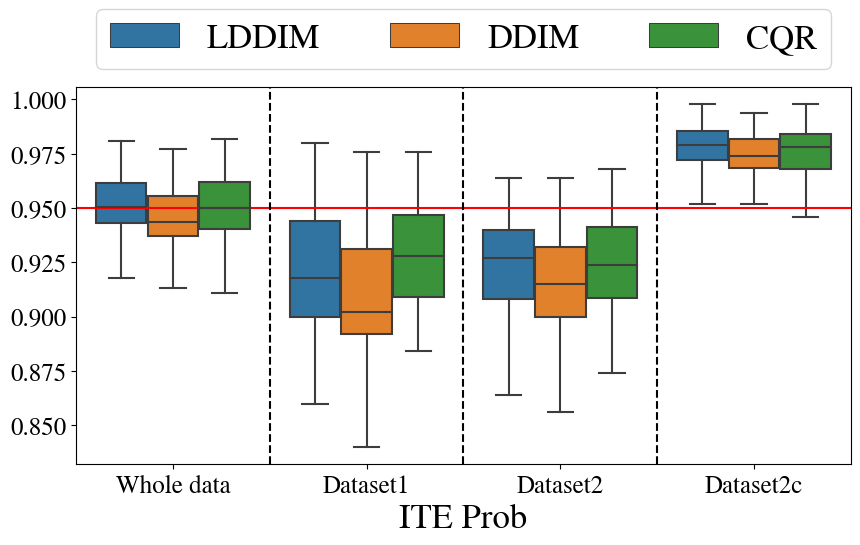

In [29]:
method_order=["LDDIM", "DDIM", "CQR"]
sns.boxplot(data=all_res_df, y="ITE", x="data", hue="method1", showfliers=False, hue_order=method_order, orient='v')
plt.axhline(y=0.95, color="red");
plt.ylabel("")
plt.xlabel("ITE Prob")
for s_ix in range(3):
    plt.axvline(x=s_ix+0.5, color="black", ls="--")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=3)

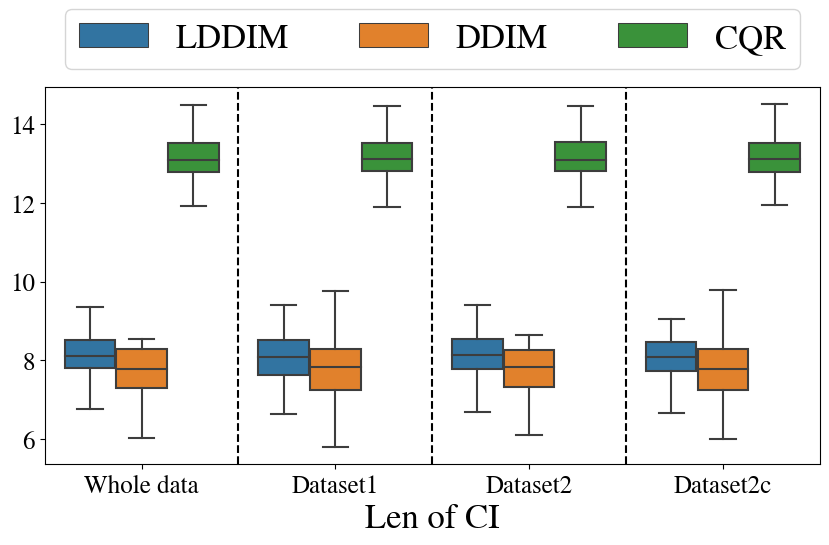

In [30]:
method_order=["LDDIM", "DDIM", "CQR"]
sns.boxplot(data=all_res_df, y="Len", x="data", hue="method1", showfliers=False, hue_order=method_order, orient='v')
plt.ylabel("")
plt.xlabel("Len of CI");
for s_ix in range(3):
    plt.axvline(x=s_ix+0.5, color="black", ls="--")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=3)